In [45]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.svm import SVC

%matplotlib inline

In [46]:
digits = np.array([0,1,2,3,4,5,6,7,8,9])
onehot_encoder = OneHotEncoder(sparse=False)
int_encoded = digits.reshape(-1,1)
onehot_encoded = onehot_encoder.fit_transform(int_encoded) #(10,10) matrix, as taught by Andrew about Dummy Variables

In [47]:
onehot_encoded[2]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [48]:
#creating a list of train dataset tuple(image, image tag)
train_dict = []
with open('train_data.txt', 'r') as f:
    for line in f:
        x, y = line.split()
        y = int (y)
        t=(x,y)
        train_dict.append(t)

In [49]:
#creating a list of test dataset tuple(image, image tag)
test_dict = []
with open('test_data.txt', 'r') as f:
    for line in f:
        x, y = line.split()
        y = int (y)
        t=(x,y)
        test_dict.append(t)

In [50]:
# Defining a function to load dataset
def load_images_dataset(data_dict,onehot_encoded,digits):
    dataset = {}
    X=[]
    Y=[]
    for aTuple in data_dict:
        x = cv2.imread(aTuple[0]) 
        if aTuple[1] in digits :
            y = onehot_encoded[aTuple[1]] # get correct onehot encoded value
            X.append(x)
            Y.append(y)
    dataset = {'X': X ,'Y':Y}
    return dataset

In [51]:
train = load_images_dataset(train_dict,onehot_encoded,digits)

In [52]:
train_x=train['X']
train_y=train['Y']

In [53]:
train_y = np.array(train_y).astype(np.float32)

In [54]:
##convert the image to sobel
sobel_train=[]
scale = 1
delta = 0
ddepth = cv2.CV_16S
for i in range(0 , len(train_x)):
    gray = cv2.cvtColor(train_x[i],cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray,ddepth,1,0,ksize = 3, scale = scale, delta = delta,borderType = cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(gray,ddepth,0,1,ksize = 3, scale = scale, delta = delta, borderType = cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)   # converting back to uint8
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    dst = cv2.addWeighted(abs_grad_x,0.5,abs_grad_y,0.5,0)
    sobel_train.append(dst)

In [55]:
sobel_train = np.array(sobel_train).astype(np.float32)

In [56]:
sobel_train.shape

(73257, 32, 32)

In [57]:
sobel_train[0].shape

(32, 32)

In [58]:
m=[]
for i in range (0,len(sobel_train)): 
    m.append(sobel_train[i].reshape(-1))

In [59]:
train_x = m

In [60]:
train_x = np.array(train_x).astype(np.float32)

In [61]:
train_x.shape

(73257, 1024)

In [62]:
# Parameters
learning_rate = 1
training_epochs = 20

In [63]:
# Network Parameters
n_hidden_1 = 512 # 1st layer number of features
n_hidden_2 = 512 # 2nd layer number of features
n_input = 1024 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
n_samples = len(train_x)

In [64]:
import tensorflow as tf
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

In [65]:
x.shape

TensorShape([Dimension(None), Dimension(1024)])

In [66]:
def multilayer_perceptron(x, weights, biases):
    '''
    x : Place Holder for Data Input
    weights: Dictionary of weights
    biases: Dicitionary of biases
    '''
    
    # First Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    # Second Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    
    # Last Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [67]:
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

In [68]:
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [69]:
# Construct model
pred = multilayer_perceptron(x, weights, biases)

In [70]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [71]:
# Initializing the variables
init = tf.global_variables_initializer()

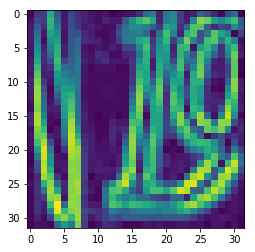

In [72]:
plt.imshow(train_x[0].reshape(32,32))

In [73]:
# Launch the session
sess = tf.InteractiveSession()

# Intialize all the variables
sess.run(init)

# Training Epochs
# Essentially the max amount of loops possible before we stop
# May stop earlier if cost/loss limit was set
for epoch in range(training_epochs):

    _, c = sess.run([optimizer, cost], feed_dict={x: train_x, y: train_y})

        # Compute average loss
    avg_cost = c

    print("Epoch: {} cost={:.4f}".format(epoch+1,avg_cost))

print("Model has completed {} Epochs of Training".format(training_epochs))

Epoch: 1 cost=890647.8125
Epoch: 2 cost=1629192448.0000
Epoch: 3 cost=402437504.0000
Epoch: 4 cost=382.3576
Epoch: 5 cost=361.4853
Epoch: 6 cost=281.0370
Epoch: 7 cost=179.4424
Epoch: 8 cost=70.9651
Epoch: 9 cost=29.3565
Epoch: 10 cost=15.5885
Epoch: 11 cost=10.0278
Epoch: 12 cost=7.5646
Epoch: 13 cost=5.5389
Epoch: 14 cost=5.0751
Epoch: 15 cost=4.5437
Epoch: 16 cost=4.0081
Epoch: 17 cost=3.5071
Epoch: 18 cost=3.0623
Epoch: 19 cost=2.7318
Epoch: 20 cost=2.5959
Model has completed 20 Epochs of Training


In [74]:
correct_predictions = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

In [75]:
print(correct_predictions[0])

Tensor("strided_slice_2:0", shape=(), dtype=bool)


In [76]:
correct_predictions = tf.cast(correct_predictions, "float")
print(correct_predictions[0])

Tensor("strided_slice_3:0", shape=(), dtype=float32)


In [77]:
accuracy = tf.reduce_mean(correct_predictions)
type(accuracy)

tensorflow.python.framework.ops.Tensor

In [78]:
test = load_images_dataset(test_dict,onehot_encoded,digits)
test_x = test['X']
test_y = test['Y']

In [79]:
##convert the image to sobel
sobel_test=[]
#gray_train=[]
scale = 1
delta = 0
ddepth = cv2.CV_16S
for i in range(0 , len(test_x)):
    gray = cv2.cvtColor(test_x[i],cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray,ddepth,1,0,ksize = 3, scale = scale, delta = delta,borderType = cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(gray,ddepth,0,1,ksize = 3, scale = scale, delta = delta, borderType = cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)   # converting back to uint8
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    dst = cv2.addWeighted(abs_grad_x,0.5,abs_grad_y,0.5,0)
    sobel_test.append(dst)

In [80]:
sobel_test = np.array(sobel_test).astype(np.float32)

In [81]:
sobel_test.shape

(26032, 32, 32)

In [82]:
n=[]
for i in range (0,len(sobel_test)): 
    n.append(sobel_test[i].reshape(-1))

In [83]:
test_x = n

In [84]:
test_x = np.array(test_x).astype(np.float32)

In [85]:
test_x.shape

(26032, 1024)

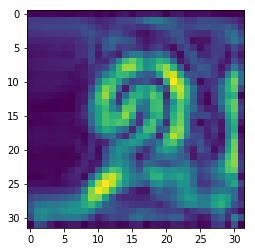

In [86]:
plt.imshow(test_x[1].reshape(32,32))

In [87]:
test_y = np.array(test_y).astype(np.float32)

In [88]:
test_y.shape

(26032, 10)

In [89]:
print("Accuracy:", accuracy.eval({x: np.array(test_x), y: np.array(test_y)}))

Accuracy: 0.19583589
